# Evaluation of results from the simulations for the different scenarios
1. Reserved bandwidth for the different services at the different nodes
2. Latencies of the different services at different receivers
3. Queue lengths of the different priorities at the different nodes

In [7]:
import pandas as pd
import numpy as np
import re
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline  

In [8]:
# # read the omnetpp csv results into panda data frames.
# reservation = pd.read_csv('reservedBandwidth.csv')
# latencies = pd.read_csv('serviceLatencies.csv')
# queues = pd.read_csv('allQueueLengths.csv')

## Definitions

## Frequently used functions

In [9]:
def parse_if_number(s):
    try: return float(s)
    except: return True if s=="true" else False if s=="false" else s if s else None

def parse_ndarray(s):
    return np.fromstring(s, sep=' ') if s else None

def parseCSV(csvFile):
    return pd.read_csv(csvFile, converters = {
        'attrvalue': parse_if_number,
        'binedges': parse_ndarray,
        'binvalues': parse_ndarray,
        'vectime': parse_ndarray,
        'vecvalue': parse_ndarray})

def moduleIdxIsNaN(data, idx):
    return data['module'][idx] is np.nan

def idxHasVecVal(data, idx):
    return data['vecvalue'][idx] is not None

def getVecValAndTime(data, i, j):
    return data['vecvalue'][i][j], data['vectime'][i][j]

def isModuleSwitchPort(module):
    return '.S[' in module and '.etherMAC[' in module

def isModuleNode(module):
    return '.N[' in module

def isModuleService(module):
    return '.services[' in module

def removeNetworkFromModule(module):
    # remove everything before the first dot
    return module[module.find('.')+1:]

def isStatReservedBandwidth(stat):
    return 'reservedBandwidth' in stat

def isStatServiceLatency(stat):
    return 'rxLatency' in stat

def isStatCredit(stat):
    return 'credit' in stat

def getRunName(run):
    return run.split('-')[0]

def getParamForModule(data, module, param):
    moduleParamPath = "**." + removeNetworkFromModule(module) + "." + param
    # filter data for 'type' = param
    for i in range(0, len(data)):
        if data['type'][i] == "config" and data['attrname'][i] == moduleParamPath:
            return data['attrvalue'][i]
    return None

def findServiceIdForModule(data, module):
    return int(getParamForModule(data, module, "serviceId"))
    
def parseModuleNameQueue(module):
    if isModuleNode(module):
        nodeNo = int(re.search(r'N\[(.*?)\]', module).group(1))
        cbsPrio = int(re.search(r'queue\[(.*?)\]', module).group(1))
        return "N[{}] Queue[{}]".format(nodeNo, cbsPrio)
    elif isModuleSwitchPort(module):
        switchNo = int(re.search(r'S\[(.*?)\]', module).group(1))
        portNo = int(re.search(r'etherMAC\[(.*?)\]', module).group(1))
        cbsPrio = int(re.search(r'queue\[(.*?)\]', module).group(1))
        return "S[{}] Port[{}] Queue[{}]".format(switchNo, portNo, cbsPrio)
    return None
    
def parseModuleNameShaper(module):
    if isModuleNode(module):
        return parseModuleNameNodeCBS(module)
    elif isModuleSwitchPort(module):
        return parseModuleNameSwitchCBS(module)
    return None
    
def parseModuleNameSwitchCBS(module):
    # extract switch and algorithm number from SomeIp_Qos_Small.S[0].etherMAC[0].shaper.transmissionSelectionAlgorithm[5] 
    if isModuleSwitchPort(module):
        switchNo = int(re.search(r'S\[(.*?)\]', module).group(1))
        portNo = int(re.search(r'etherMAC\[(.*?)\]', module).group(1))
        cbsPrio = int(re.search(r'Algorithm\[(.*?)\]', module).group(1))
        return "S[{}] Port[{}] Queue[{}] CBS".format(switchNo, portNo, cbsPrio)
    return None

def parseModuleNameNodeCBS(module):
    # extract node and algorithm number from SomeIp_Qos_Small.N[0].shaper.transmissionSelectionAlgorithm[5] 
    if isModuleNode(module):
        nodeNo = int(re.search(r'N\[(.*?)\]', module).group(1))
        cbsPrio = int(re.search(r'Algorithm\[(.*?)\]', module).group(1))
        return "N[{}] Queue[{}] CBS".format(nodeNo, cbsPrio)
    return None

def parseNodeName(module):
    if isModuleNode(module):
        nodeNo = int(re.search(r'N\[(.*?)\]', module).group(1))
        return "N[{}]".format(nodeNo)

def parseServiceName(data, module):
    if isModuleService(module):
        serviceId = findServiceIdForModule(data, module)
        return "ServiceId {}".format(serviceId)
    return None


## 1. Reserved bandwidth for the different services at the different nodes

In [10]:
# read the omnetpp csv results into a panda data frame
reservation = parseCSV('reservedBandwidth.csv')
reservation.head()   

,run,type,module,name,attrname,attrvalue,vectime,vecvalue
0,SmallEvalCase_ReducedPayload_FixedCMI_NoSource...,runattr,NaN,NaN,configname,SmallEvalCase_ReducedPayload_FixedCMI_NoSourceCT,None,None
1,SmallEvalCase_ReducedPayload_FixedCMI_NoSource...,runattr,NaN,NaN,datetime,20240229-12:04:31,None,None
2,SmallEvalCase_ReducedPayload_FixedCMI_NoSource...,runattr,NaN,NaN,datetimef,20240229-120431,None,None
3,SmallEvalCase_ReducedPayload_FixedCMI_NoSource...,runattr,NaN,NaN,experiment,SmallEvalCase_ReducedPayload_FixedCMI_NoSourceCT,None,None
4,SmallEvalCase_ReducedPayload_FixedCMI_NoSource...,runattr,NaN,NaN,inifile,omnetpp.ini,None,None


In [11]:
# iterate over the modules find the switches (S[*]) and print their reserved bandwidth
runCBSReservation = dict()
for i in range(0, len(reservation)):
    if moduleIdxIsNaN(reservation, i):
        continue
    if isModuleSwitchPort(reservation['module'][i]):
        if isStatReservedBandwidth(reservation['name'][i]):
            # filter reservation['vecvalue'][i] for non zero values and print them
            if not idxHasVecVal(reservation, i):
                continue
            for j in range(0, len(reservation['vecvalue'][i])):
                val, time = getVecValAndTime(reservation, i, j)
                if val != 0:
                    # insert values into switchBandwidth dict
                    runName = getRunName(reservation['run'][i])
                    if runName not in runCBSReservation:
                        runCBSReservation[runName] = dict()
                    switchName = parseModuleNameSwitchCBS(reservation['module'][i])
                    if switchName not in runCBSReservation[runName]:
                        runCBSReservation[runName][switchName] = dict()
                    runCBSReservation[runName][switchName][time] = val
runCBSReservation


{'SmallEvalCase_ReducedPayload_NC_NoSourceCT': {'S[0] Port[0] Queue[7] CBS': {0.02076849: 70101196.0},
  'S[1] Port[1] Queue[7] CBS': {0.02076849: 70101196.0},
  'S[2] Port[1] Queue[7] CBS': {0.02076849: 70101196.0}},
 'SmallEvalCase_ReducedPayload_NC_MinIdleSlopes_NoSourceCT': {'S[0] Port[0] Queue[7] CBS': {0.02076849: 52120383.0},
  'S[1] Port[1] Queue[7] CBS': {0.02076849: 52120383.0},
  'S[2] Port[1] Queue[7] CBS': {0.02076849: 52120383.0}},
 'SmallEvalCase_ReducedPayload_FixedCMI_NoSourceCT': {'S[0] Port[0] Queue[7] CBS': {0.02076849: 48832000.0},
  'S[1] Port[1] Queue[7] CBS': {0.02076849: 48832000.0},
  'S[2] Port[1] Queue[7] CBS': {0.02076849: 48832000.0}},
 'SmallEvalCase_ReducedPayload_NoSourceCT': {'S[0] Port[0] Queue[7] CBS': {0.02076849: 6144000.0},
  'S[1] Port[1] Queue[7] CBS': {0.02076849: 6144000.0},
  'S[2] Port[1] Queue[7] CBS': {0.02076849: 6144000.0}}}

In [12]:
# output the switchBandwidth dict to csv
for run in runCBSReservation.keys():
    switchCBSBandwidthDF = pd.DataFrame.from_dict(runCBSReservation[run])
    # sord inner dict by key
    switchCBSBandwidthDF = switchCBSBandwidthDF.apply(lambda x: x.sort_index())
    switchCBSBandwidthDF.to_csv("export/bandwidth"+run+".csv", index=True, header=True, sep=';')

In [13]:
# also create one common csv file for all runs
switchCBSBandwidthDF = pd.DataFrame.from_dict(runCBSReservation)
# sord inner dict by key
switchCBSBandwidthDF = switchCBSBandwidthDF.apply(lambda x: x.sort_index())
switchCBSBandwidthDF.to_csv("export/bandwidth.csv", index=True, header=True, sep=';')

## 2. Latencies of the different services at different receivers

In [14]:
# read the omnetpp csv results into a panda data frame
latencies = parseCSV('latency.csv')
latencies.head()   


,run,type,module,name,attrname,attrvalue,vectime,vecvalue
0,SmallEvalCase_ReducedPayload_FixedCMI_NoSource...,runattr,NaN,NaN,configname,SmallEvalCase_ReducedPayload_FixedCMI_NoSourceCT,None,None
1,SmallEvalCase_ReducedPayload_FixedCMI_NoSource...,runattr,NaN,NaN,datetime,20240229-12:04:31,None,None
2,SmallEvalCase_ReducedPayload_FixedCMI_NoSource...,runattr,NaN,NaN,datetimef,20240229-120431,None,None
3,SmallEvalCase_ReducedPayload_FixedCMI_NoSource...,runattr,NaN,NaN,experiment,SmallEvalCase_ReducedPayload_FixedCMI_NoSourceCT,None,None
4,SmallEvalCase_ReducedPayload_FixedCMI_NoSource...,runattr,NaN,NaN,inifile,omnetpp.ini,None,None


In [15]:
runLatencies = dict()
for i in range(0, len(latencies)):
    if moduleIdxIsNaN(latencies, i):
        continue
    if isModuleService(latencies['module'][i]):
        if isStatServiceLatency(latencies['name'][i]):
            if not idxHasVecVal(latencies, i):
                continue
            runName = getRunName(latencies['run'][i])
            if runName not in runLatencies:
                runLatencies[runName] = dict()
            node = parseNodeName(latencies['module'][i])
            if node not in runLatencies[runName]:
                runLatencies[runName][node] = dict()
            service = parseServiceName(latencies, latencies['module'][i])
            if service not in runLatencies[runName][node]:
                runLatencies[runName][node][service] = dict()
            for j in range(0, len(latencies['vecvalue'][i])):
                val, time = getVecValAndTime(latencies, i, j)
                runLatencies[runName][node][service][time] = val
runLatencies

{'SmallEvalCase_ReducedPayload_FixedCMI_NoSourceCT': {'N[2]': {'ServiceId 0': {0.0212642: 0.0002642,
    0.0226323: 0.0006323,
    0.023410723225: 0.000410723225,
    0.0242642: 0.0002642,
    0.02532986011: 0.00032986011,
    0.026315148702: 0.000315148702,
    0.027400316942: 0.000400316942,
    0.028276020524: 0.000276020524,
    0.029396580527: 0.000396580527,
    0.030354021669: 0.000354021669,
    0.031266168035: 0.000266168035,
    0.032306887724: 0.000306887724,
    0.033345332639: 0.000345332639,
    0.034417152404: 0.000417152404,
    0.035383587579: 0.000383587579,
    0.036265455823: 0.000265455823,
    0.037396618294: 0.000396618294,
    0.038356915631: 0.000356915631,
    0.039425098598: 0.000425098598,
    0.040349636714: 0.000349636714,
    0.041458555012: 0.000458555012,
    0.042269719734: 0.000269719734,
    0.043363320463: 0.000363320463,
    0.044356112832: 0.000356112832,
    0.045301579444: 0.000301579444,
    0.0462642: 0.0002642,
    0.047477743841: 0.000477743

In [16]:
# plot the latencies one graph per run containing all nodes and services
for run in runLatencies.keys():
    fig, ax = plt.subplots()
    for node in runLatencies[run].keys():
        for service in runLatencies[run][node].keys():
            x = runLatencies[run][node][service].keys()
            y = runLatencies[run][node][service].values()
            ax.plot(x, y, label=node + " " + service)
    ax.legend()
    ax.set_xlabel('time')
    ax.set_ylabel('latency [s]')
    ax.set_title('Latencies for run ' + run)
    ax.grid(True)
    ax.set_xlim(0, 2)  # set x-axis limits to 0-100ms
    ax.set_ylim(0, 0.001)  # show latencies below 1ms
    fig.savefig("export/latencies"+run+".png", dpi=300, bbox_inches='tight')
    plt.close(fig)

In [27]:
# plot the latencies one graph per service containing all nodes for all runs
tmpFigs = dict()
tmpAxs = dict()
deadlines = {
    # "ServiceId 1 N[3]":0.001,
    # "ServiceId 3 N[3]":0.005,
    "ServiceId 0 N[2]":0.001,
    # "ServiceId 3 N[2]":0.005,
    # "ServiceId 2 N[1]":0.010
}
for run in runLatencies.keys():
    for node in runLatencies[run].keys():
        for service in runLatencies[run][node].keys():
            key = service + " " + node
            if key not in tmpFigs:
                tmpFigs[key], tmpAxs[key] = plt.subplots()
            x = runLatencies[run][node][service].keys()
            y = runLatencies[run][node][service].values()
            tmpAxs[key].plot(x, y, label=run, linewidth=0.5, linestyle='solid')
for name in tmpFigs.keys():
    # add deadline for the name to the plot
    tmpAxs[name].axhline(y=deadlines[name], color='r', linestyle='-', label="deadline")
    tmpAxs[name].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3)
    tmpAxs[name].set_xlabel('time')
    tmpAxs[name].set_ylabel('latency [s]')
    tmpAxs[name].set_title('Latencies for ' + name)
    tmpAxs[name].grid(True)
    tmpAxs[name].set_xlim(0, 0.1)  # set 
    tmpAxs[name].set_ylim(0, deadlines[name] + 0.0001)  # show latencies below 1ms
    tmpFigs[name].savefig("export/latencies"+name+".png", dpi=300, bbox_inches='tight')
    plt.close(tmpFigs[name])

In [63]:
# plot the max latency of different algorithms compared to the simulation
maxLatencies = pd.read_csv('max_latencies.csv')
# Remove spaces in column names
maxLatencies = maxLatencies.rename(columns=lambda x: x.replace(" ", ""))
scenariosMap = {
    "SmallEvalCase_ReducedPayload_FixedCMI_NoSourceCT": "FixedCMI",
    "SmallEvalCase_ReducedPayload_NC_MinIdleSlopes_NoSourceCT": "NCMin",
    "SmallEvalCase_ReducedPayload_NC_NoSourceCT": "NCMax",
    "SmallEvalCase_ReducedPayload_NoSourceCT": "FlowRate"
}
node = "N[2]"
service = "ServiceId 0"

for run in runLatencies.keys():
    fig, ax = plt.subplots()
    row = maxLatencies[maxLatencies['Name'] == scenariosMap[run]]
    idle_slope = row['IdleSlope'].values[0]
    #create a plot for each scenario
    title = scenariosMap[run] + "-" + str(idle_slope) + " for " + node + " " + service
    x = runLatencies[run][node][service].keys()
    y = runLatencies[run][node][service].values()
    ax.plot(x, y, label="Simulation")
    # add deadline for the name to the plot
    ax.axhline(y=0.001, color='red', linestyle='-', label="deadline")
    ax.axhline(y=row['BA'].values[0], color='purple', linestyle='--', label="BA")
    ax.axhline(y=row['Q'].values[0], color='green', linestyle='--', label="Q")
    ax.axhline(y=row['P100'].values[0], color='orange', linestyle='--', label="P100")
    ax.axhline(y=row['PFaster'].values[0], color='black', linestyle='--', label="PFaster")
    ax.axhline(y=row['PFasterV2'].values[0], color='gray', linestyle='--', label="PFasterV2")
    # place the legend outside the plot
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3)
    ax.set_xlabel('time')
    ax.set_ylabel('latency [s]')
    ax.set_title(title)
    ax.grid(True)
    ax.set_xlim(0, 0.1)  # set
    ax.set_ylim(0, 0.002)  # show latencies below 1ms
    fig.savefig("export/latencies"+title+".png", dpi=300, bbox_inches='tight')
    plt.close(fig)

## 3. Queue lengths of the different priorities at the different nodes

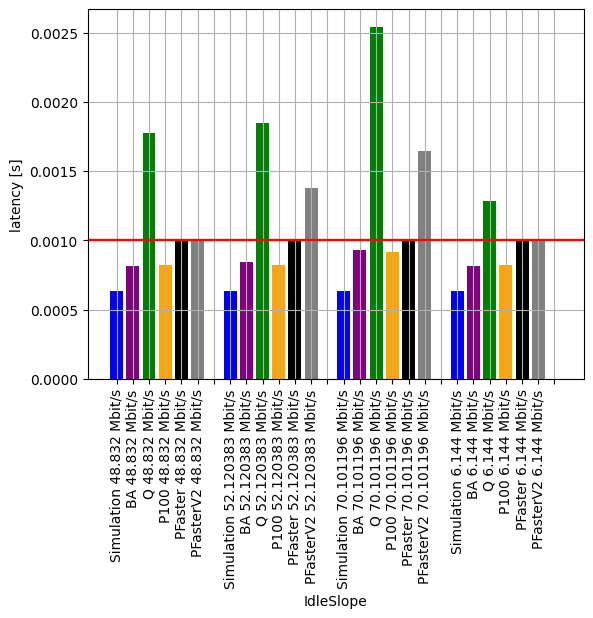

In [84]:
# create a bar plot showing the calculated and simulated max latency for each scenario
fig, ax = plt.subplots()
# rotate x labels 
plt.xticks(rotation=90)
ax.set_xlabel('IdleSlope')
ax.set_ylabel('latency [s]')
ax.grid(True)
space = " "
for run in runLatencies.keys():
    maxLatencySimulated = np.max(runLatencies[run][node][service].values())
    row = maxLatencies[maxLatencies['Name'] == scenariosMap[run]]
    idle_slope = row['IdleSlope'].values[0] / 1000000
    ax.axhline(y=0.001, color='red', linestyle='-', label="deadline")
    title = scenariosMap[run] + "-" + str(idle_slope) + " for " + node + " " + service
    ax.bar("Simulation " + str(idle_slope) + " Mbit/s", maxLatencySimulated, color='blue')
    ax.bar("BA " + str(idle_slope) + " Mbit/s", row['BA'].values[0], color='purple')
    ax.bar("Q " + str(idle_slope) + " Mbit/s", row['Q'].values[0], color='green')
    ax.bar("P100 " + str(idle_slope) + " Mbit/s", row['P100'].values[0], color='orange')
    ax.bar("PFaster " + str(idle_slope) + " Mbit/s", row['PFaster'].values[0], color='black')
    ax.bar("PFasterV2 " + str(idle_slope) + " Mbit/s", row['PFasterV2'].values[0], color='gray')
    # add empty bar to create space between the different scenarios
    ax.bar(space, 0, color='white')
    space += " "

In [18]:
# # read the omnetpp csv results into a panda data frame
# queues = parseCSV('allQueueLengths.csv')
# queues.head()

In [19]:
# # determine min max and average queue lengths for each run, node port and queue
# runQueueLengths = dict()
# for i in range(0, len(queues)):
#     if moduleIdxIsNaN(queues, i):
#         continue
#     moduleName = parseModuleNameQueue(queues['module'][i])
#     if moduleName is None or not idxHasVecVal(queues, i):
#         continue
#     runName = getRunName(queues['run'][i])
#     if runName not in runQueueLengths:
#         runQueueLengths[runName] = dict()
#     if moduleName not in runQueueLengths[runName]:
#         runQueueLengths[runName][moduleName] = dict()
#     runQueueLengths[runName][moduleName]['min'] = min(queues['vecvalue'][i])
#     runQueueLengths[runName][moduleName]['max'] = max(queues['vecvalue'][i])
#     runQueueLengths[runName][moduleName]['avg'] = sum(queues['vecvalue'][i])/len(queues['vecvalue'][i])

In [20]:
# # plot the min max avg queue lengths as boxes one graph per run containing all nodes and services
# for run in runQueueLengths.keys():
#     fig, ax = plt.subplots()
#     for node in runQueueLengths[run].keys():
#         ax.plot([node, node], [runQueueLengths[run][node]['min'], runQueueLengths[run][node]['max']], solid_capstyle="butt")
#         ax.plot(node, [runQueueLengths[run][node]['avg']], marker="o")
#     ax.set_ylabel('queue length [#packets]')
#     ax.set_title('Queue lengths for run ' + run)
#     ax.grid(True)
#     ax.tick_params(axis='x', rotation=90)
#     fig.savefig("export/queues"+run+".png", dpi=300, bbox_inches='tight')
#     plt.close(fig)

In [21]:
# # plot the min max avg queue lengths as boxes one graph per node containing all runs
# tmpFigs = dict()
# tmpAxs = dict()
# for run in runQueueLengths.keys():
#     for node in runQueueLengths[run].keys():
#         key = node
#         if key not in tmpFigs:
#             tmpFigs[key], tmpAxs[key] = plt.subplots()
#         tmpAxs[key].plot([run, run], [runQueueLengths[run][node]['min'], runQueueLengths[run][node]['max']], solid_capstyle="butt")
#         tmpAxs[key].plot(run, [runQueueLengths[run][node]['avg']], marker="o")
# for name in tmpFigs.keys():
#     tmpAxs[name].set_ylabel('queue length [#packets]')
#     tmpAxs[name].set_title('Queue lengths for ' + name)
#     tmpAxs[name].grid(True)
#     tmpAxs[name].tick_params(axis='x', rotation=90)
#     tmpFigs[name].savefig("export/queues"+name+".png", dpi=300, bbox_inches='tight')
#     plt.close(tmpFigs[name])    

## 4. Credit Vector

In [22]:
# read the omnetpp csv results into a panda data frame
credit = parseCSV('credit.csv')
credit.head()   

,run,type,module,name,attrname,attrvalue,vectime,vecvalue
0,SmallEvalCase_ReducedPayload_FixedCMI_NoSource...,runattr,NaN,NaN,configname,SmallEvalCase_ReducedPayload_FixedCMI_NoSourceCT,None,None
1,SmallEvalCase_ReducedPayload_FixedCMI_NoSource...,runattr,NaN,NaN,datetime,20240229-12:04:31,None,None
2,SmallEvalCase_ReducedPayload_FixedCMI_NoSource...,runattr,NaN,NaN,datetimef,20240229-120431,None,None
3,SmallEvalCase_ReducedPayload_FixedCMI_NoSource...,runattr,NaN,NaN,experiment,SmallEvalCase_ReducedPayload_FixedCMI_NoSourceCT,None,None
4,SmallEvalCase_ReducedPayload_FixedCMI_NoSource...,runattr,NaN,NaN,inifile,omnetpp.ini,None,None


In [23]:
credits = dict()
for i in range(0, len(credit)):
    if moduleIdxIsNaN(credit, i):
        continue
    if not idxHasVecVal(credit, i):
        continue
    if not isStatCredit(credit['name'][i]):
        continue
    runName = getRunName(credit['run'][i])
    if runName not in credits:
        credits[runName] = dict()
    node = parseModuleNameShaper(credit['module'][i])
    if node is None:
        continue
    if node not in credits[runName]:
        credits[runName][node] = dict()
    for j in range(0, len(credit['vecvalue'][i])):
        val, time = getVecValAndTime(credit, i, j)
        credits[runName][node][time] = val
credits

    

{'SmallEvalCase_ReducedPayload_NC_NoSourceCT': {'S[2] Port[1] Queue[7] CBS': {0.02080963: 0.0,
   0.02120415: 0.0,
   0.021265108476: -1823.0,
   0.02126511: -1823.0,
   0.02127183: -1352.0,
   0.021291187824: 0.0,
   0.02232617: 0.0,
   0.02244921: 0.0,
   0.02244926: 0.0,
   0.02257225: 8620.0,
   0.022633208476: 6797.0,
   0.02263321: 6797.0,
   0.022779546609: 0.0,
   0.022906253271: 0.0,
   0.023029293271: 0.0,
   0.023292096509: 0.0,
   0.023350673225: 4106.0,
   0.023411631701: 2283.0,
   0.023411633225: 2283.0,
   0.023534673225: 0.0,
   0.023657713225: 0.0,
   0.023953115902: 0.0,
   0.024076155902: 0.0,
   0.024199195902: 0.0,
   0.02420415: 0.0,
   0.024265108476: -1823.0,
   0.02426511: -1823.0,
   0.024291187824: 0.0,
   0.024431966053: 0.0,
   0.02457838174: 0.0,
   0.02470142174: 0.0,
   0.02489669411: 0.0,
   0.02501973411: 0.0,
   0.02520773011: 0.0,
   0.02526981011: 4352.0,
   0.025330768586: 2529.0,
   0.02533077011: 2529.0,
   0.02545381011: 0.0,
   0.02557685011: 

In [24]:
# plot credits one graph per run containing all node and switche ports
for run in credits.keys():
    fig, ax = plt.subplots()
    for node in credits[run].keys():
        x = credits[run][node].keys()
        y = credits[run][node].values()
        ax.plot(x, y, label=node)
    ax.legend()
    ax.set_xlabel('time')
    ax.set_ylabel('credit [bytes]')
    ax.set_title('Credits for run ' + run)
    ax.grid(True)
    ax.set_xlim(0, 2)  # set x-axis limits to 0-100ms
    fig.savefig("export/credits"+run+".png", dpi=300, bbox_inches='tight')
    plt.close(fig)

In [25]:
# plot credits one graph per node containing all runs
tmpFigs = dict()
tmpAxs = dict()
for run in credits.keys():
    for node in credits[run].keys():
        key = node
        if key not in tmpFigs:
            tmpFigs[key], tmpAxs[key] = plt.subplots()
        x = credits[run][node].keys()
        y = credits[run][node].values()
        tmpAxs[key].plot(x, y, label=run)
for name in tmpFigs.keys():
    tmpAxs[name].legend()
    tmpAxs[name].set_xlabel('time')
    tmpAxs[name].set_ylabel('credit [bytes]')
    tmpAxs[name].set_title('Credits for ' + name)
    tmpAxs[name].grid(True)
    tmpAxs[name].set_xlim(0, 2)  # set x-axis limits to 0-100ms
    tmpFigs[name].savefig("export/credits"+name+".png", dpi=300, bbox_inches='tight')
    plt.close(tmpFigs[name])

In [26]:
# plot credits one graph per node and run
for run in credits.keys():
    for node in credits[run].keys():
        fig, ax = plt.subplots()
        x = credits[run][node].keys()
        y = credits[run][node].values()
        ax.plot(x, y)
        ax.set_xlabel('time')
        ax.set_ylabel('credit [bytes]')
        ax.set_title('Credits for ' + node + " in run " + run)
        ax.grid(True)
        ax.set_xlim(0, 2)  # set x-axis limits to 0-100ms
        fig.savefig("export/credits"+node+run+".png", dpi=300, bbox_inches='tight')
        plt.close(fig)